# Xây dựng và tối ưu danh mục đầu tư

#### Cài đặt các thư viện

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### Phần 1: Chuẩn bị dữ liệu cổ phiếu S&P 500

#### 1.1 Lấy danh sách các cổ phiếu trong danh mục S&P 500 từ Wikipedia

In [2]:
tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
tickers = tickers.Symbol.to_list()
print(tickers)
print(len(tickers))

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ATVI', 'ADM', 'ADBE', 'ADP', 'AES', 'AFL', 'A', 'ABNB', 'APD', 'AKAM', 'ALK', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AMD', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BBWI', 'BAX', 'BDX', 'WRB', 'BRK.B', 'BBY', 'BIO', 'TECH', 'BIIB', 'BLK', 'BX', 'BK', 'BA', 'BKNG', 'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF.B', 'BG', 'CHRW', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CTLT', 'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'COR', 'CNC', 'CNP', 'CDAY', 'CF', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'COP', 'ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CTVA', 'CSGP', 'COST', 'CTRA', 'CCI', 'C

#### 1.2 Xác định khoảng thời gian lấy dữ liệu

Lưu ý: Giờ giao dịch tiêu chuẩn của NYSE theo giờ Việt Nam:
* Mùa đông: 21h30 - 4h00 ngày hôm sau;
* Mùa hè: 20h30 - 3h00 ngày hôm sau.

Chỉ lấy dữ liệu sau mốc 4h để đảm bảo đúng thời gian lấy giá đóng cửa phiên giao dịch hôm qua.

Ghi chú: 
* Lấy dữ liệu lúc 4h10 (mùa hè) vẫn chưa có kết quả của phiên trước;
* Lấy dữ liệu lúc 9h00 (mùa hè) vẫn chưa có kết quả của phiên trước;
* Lấy dữ liệu lúc 9h30 (mùa hè) nhận được kết quả của phiên trước;
* Lấy dữ liệu lúc 10h40 (mùa hè) nhận được kết quả của phiên trước.

In [3]:
# Mốc thời gian kết thúc: hôm qua
end_date = datetime.datetime.today() - datetime.timedelta(days=3)
print(end_date)

2023-10-04 23:09:07.023439


In [4]:
# Mốc thời gian bắt đầu: cách hôm qua 730 ngày (3 năm)
start_date = end_date - datetime.timedelta(days=730)
print(start_date)

2021-10-04 23:09:07.023439


#### 1.3 Lấy dữ liệu cổ phiếu từ Yahoo Finance

Ghi chú: Mỗi lần thử lại có số lượng tải thành công khác nhau

Phán đoán: do kết nối Internet

Xử lý: 
* Đảm bảo đường truyền Internet
* Nếu số lượng completed tăng chậm và không đều thì phải tải lại

Lưu ý: 
* Tải các cổ phiếu S&P 500 trong điều kiện đường truyền tốt chỉ có 2 cổ phiếu tải thất bại: BF.B, BRK.B
* Tải các cổ phiếu S&P 100 trong điều kiện đường truyền tốt chỉ có 1 cổ phiếu tải thất bại: BRK.B

In [5]:
# Tải dữ liệu cổ phiếu
stocks_data = yf.download(tickers, start_date, end_date, auto_adjust=True)

[*********************100%%**********************]  503 of 503 completed


2 Failed downloads:
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2021-10-04 23:09:07.023439 -> 2023-10-04 23:09:07.023439)')
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')


#### 1.4 Tạo ma trận giá cổ phiếu

In [6]:
# Tạo ma trận giá cổ phiếu
price_matrix = stocks_data["Close"]

In [7]:
# Xóa bỏ các cột tồn tại giá trị rỗng (cổ phiếu thiếu dữ liệu)
price_matrix = price_matrix.dropna(axis=1)

In [8]:
print(price_matrix)

                     A        AAL        AAPL        ABBV        ABNB  \
Date                                                                    
2021-10-05  150.989471  21.469999  139.496124  101.099075  164.740005   
2021-10-06  151.601212  20.540001  140.375961  100.923660  167.250000   
2021-10-07  153.248962  20.170000  141.651184  102.354614  169.600006   
2021-10-08  150.436935  20.070000  141.265625  102.640793  169.970001   
2021-10-11  148.019623  20.129999  141.176697  101.865303  166.669998   
...                ...        ...         ...         ...         ...   
2023-09-28  111.774643  12.920000  170.690002  152.250000  136.470001   
2023-09-29  111.595001  12.810000  171.210007  149.059998  137.210007   
2023-10-02  110.900002  12.750000  173.750000  148.250000  136.559998   
2023-10-03  110.260002  12.290000  172.399994  147.429993  127.730003   
2023-10-04  111.669998  12.730000  173.660004  147.690002  127.410004   

                   ABT       ACGL         ACN     

In [9]:
# Số phiên dữ liệu lịch sử
duration = price_matrix.shape[0]
print(duration)

503


#### 1.5 Xây dựng ma trận tỷ suất lợi nhuận theo ngày

In [10]:
# Tạo ma trận 0
return_matrix = pd.DataFrame(0, index=price_matrix.index, columns=price_matrix.columns)

In [11]:
# Tính tỷ lệ giá cổ phiếu giữa hai phiên liên tiếp
for i in range(1, duration):
    return_matrix.iloc[i] = price_matrix.iloc[i] / price_matrix.iloc[i - 1] - 1

In [12]:
print(return_matrix)

                   A       AAL      AAPL      ABBV      ABNB       ABT  \
Date                                                                     
2021-10-05  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2021-10-06  0.004052 -0.043316  0.006307 -0.001735  0.015236  0.005264   
2021-10-07  0.010869 -0.018014  0.009084  0.014179  0.014051  0.012190   
2021-10-08 -0.018349 -0.004958 -0.002722  0.002796  0.002182  0.004071   
2021-10-11 -0.016069  0.002990 -0.000630 -0.007555 -0.019415 -0.012755   
...              ...       ...       ...       ...       ...       ...   
2023-09-28  0.013575  0.024584  0.001526 -0.005747  0.018205  0.027112   
2023-09-29 -0.001607 -0.008514  0.003046 -0.020952  0.005422 -0.012943   
2023-10-02 -0.006228 -0.004684  0.014836 -0.005434 -0.004737 -0.011564   
2023-10-03 -0.005771 -0.036078 -0.007770 -0.005531 -0.064660  0.000627   
2023-10-04  0.012788  0.035801  0.007309  0.001764 -0.002505 -0.001462   

                ACGL       ACN      A

### Phần 2: Lọc các cổ phiếu phù hợp

#### 2.1 Kiểm định tính dừng

Lưu ý: luôn chạy "stationary_stocks = []" để reset trước khi chạy lệnh append để tránh thừa phần từ, nhớ check số lượng

In [13]:
# Tạo danh sách lưu các cổ phiếu thỏa mãn tính dừng
stationary_stocks = []

# Mức ý nghĩa phải <= 0.05
# Mức ý nghĩa càng nhỏ thì kiểm định càng tin cậy
alpha = 0.01

# Kiểm định Dickey–Fuller tăng cường (ADF test)
for column in return_matrix.columns:
    adf_test = adfuller(return_matrix[column])
    p_value = adf_test[1]
    if p_value <= alpha:
        stationary_stocks.append(column)
    else:
        print(column)

print(len(stationary_stocks))

497


In [14]:
return_matrix = return_matrix[stationary_stocks]
print(return_matrix.shape)

(503, 497)


(Kinh nghiệm) chuỗi thời gian tỷ lệ giá của hầu hết các tài sản đầu tư đều thỏa mãn tính dừng

#### 2.2 Kiểm định phân phối nặng đuôi

In [15]:
# Kỳ vọng
means = return_matrix.mean()
print(means)

A      -0.000418
AAL    -0.000577
AAPL    0.000610
ABBV    0.000843
ABNB    0.000067
          ...   
YUM     0.000156
ZBH    -0.000336
ZBRA   -0.001189
ZION   -0.000633
ZTS    -0.000089
Length: 497, dtype: float64


Ghi chú: Kỳ vọng của tỷ suất lợi nhuận xấp xỉ bằng 0 và thường lớn hơn 0 trong dài hạn

In [16]:
# Độ lệch chuẩn
std_devs = return_matrix.std()
print(std_devs)

A       0.019080
AAL     0.030395
AAPL    0.018736
ABBV    0.013328
ABNB    0.033972
          ...   
YUM     0.012918
ZBH     0.016855
ZBRA    0.027049
ZION    0.031547
ZTS     0.017704
Length: 497, dtype: float64


In [17]:
# Tạo series đếm số phần tử
counts = pd.Series([0 for i in range (return_matrix.shape[1])])
print(len(counts))

497


In [18]:
# Số phần tử nằm ngoài về bên trái của khoảng 3 lần độ lệch chuẩn đầu tiên (-inf; mu-3*sigma)
for i in range (len(counts)):
    supremum = means[i] - 3 * std_devs[i]
    for j in range (duration):
        if return_matrix.iloc[j, i] < supremum:
            counts[i] = counts[i] + 1

print(counts)

0      3
1      3
2      3
3      5
4      3
      ..
492    3
493    2
494    4
495    4
496    1
Length: 497, dtype: int64


In [19]:
# Tỷ lệ
ratios = counts / duration
print(ratios)

0      0.005964
1      0.005964
2      0.005964
3      0.009940
4      0.005964
         ...   
492    0.005964
493    0.003976
494    0.007952
495    0.007952
496    0.001988
Length: 497, dtype: float64


Lưu ý: Luôn chạy "std_stocks = []" để reset trước khi chạy lệnh append để tránh gán thừa phần tử

In [20]:
# Kiểm định phân phối nặng đuôi trái
std_stocks = []

# Quy tắc 3 sigma cho đuôi trái: [(100% - 99.73%) / 2]
threshold = 0.00135

for i in range (len(ratios)):
    if ratios[i] <= threshold:
        std_stocks.append(return_matrix.columns[i])

print(std_stocks)
print(len(std_stocks))

['ANSS', 'AOS', 'AVGO', 'BBWI', 'BIIB', 'CDNS', 'DHI', 'DLR', 'FSLR', 'IDXX', 'KLAC', 'LLY', 'LYB', 'MCHP', 'MS', 'NVDA', 'ON', 'PNR', 'SNPS', 'WAB']
20


In [21]:
return_matrix = return_matrix[std_stocks]
print(return_matrix.shape)

(503, 20)


#### 2.3 Kiểm định tổng giá trị giao dịch

In [22]:
# Xác định ma trận giá cho các cổ phiếu lọc ở bước trên
price_matrix = price_matrix[std_stocks]
print(price_matrix)

                  ANSS        AOS        AVGO       BBWI        BIIB  \
Date                                                                   
2021-10-05  341.359985  61.379669  459.007294  61.331161  280.440002   
2021-10-06  344.609985  61.466442  462.184509  60.069679  283.549988   
2021-10-07  348.709991  62.343849  467.044861  61.360054  287.769989   
2021-10-08  345.670013  61.929253  466.033051  61.302273  285.829987   
2021-10-11  344.109985  61.861763  465.550812  60.204502  285.589996   
...                ...        ...         ...        ...         ...   
2023-09-28  297.859985  66.480003  832.000000  33.209999  257.829987   
2023-09-29  297.549988  66.129997  830.580017  33.799999  257.010010   
2023-10-02  297.399994  66.050003  834.950012  33.570000  252.860001   
2023-10-03  287.390015  65.370003  814.830017  32.439999  251.309998   
2023-10-04  290.820007  66.239998  823.809998  32.680000  257.160004   

                  CDNS         DHI         DLR        FSLR     

In [23]:
# Tạo ma trận khối lượng giao dịch
volume_matrix = stocks_data["Volume"]
volume_matrix = volume_matrix[std_stocks]
print(volume_matrix)

              ANSS      AOS     AVGO     BBWI     BIIB     CDNS      DHI  \
Date                                                                       
2021-10-05  275400  1839900  1655700  2879100  1010500  1207900  2027700   
2021-10-06  245700  1234200  1204200  2695200   978600  1295900  2326900   
2021-10-07  241600  1224000  1326100  2518400   879900  1384700  1691200   
2021-10-08  176800  1223600  1027900  1372700   629600   581300  2119900   
2021-10-11  168100  1474300  1118600  1438500   620600   690000  1994200   
...            ...      ...      ...      ...      ...      ...      ...   
2023-09-28  443400   882300  1618000  3667700   641200  1237200  2161500   
2023-09-29  569300   996500  1647600  2837000   887600   900700  2121400   
2023-10-02  452200   935300  1467600  3162500   752400   747100  3100900   
2023-10-03  492800   859800  1876100  2509300   830000  1076700  4537100   
2023-10-04  521900   829300  1641700  2368700  1034400   832900  3115800   

           

In [24]:
# Tính ma trận tổng khối lượng giao dịch theo phiên
value_matrix = price_matrix * volume_matrix
print(value_matrix)

                    ANSS           AOS          AVGO          BBWI  \
Date                                                                 
2021-10-05  9.401054e+07  1.129325e+08  7.599784e+08  1.765785e+08   
2021-10-06  8.467067e+07  7.586188e+07  5.565626e+08  1.618998e+08   
2021-10-07  8.424833e+07  7.630887e+07  6.193482e+08  1.545292e+08   
2021-10-08  6.111446e+07  7.577663e+07  4.790354e+08  8.414963e+07   
2021-10-11  5.784489e+07  9.120280e+07  5.207651e+08  8.660418e+07   
...                  ...           ...           ...           ...   
2023-09-28  1.320711e+08  5.865531e+07  1.346176e+09  1.218043e+08   
2023-09-29  1.693952e+08  6.589854e+07  1.368464e+09  9.589060e+07   
2023-10-02  1.344843e+08  6.177657e+07  1.225373e+09  1.061651e+08   
2023-10-03  1.416258e+08  5.620513e+07  1.528703e+09  8.140169e+07   
2023-10-04  1.517790e+08  5.493283e+07  1.352449e+09  7.740912e+07   

                    BIIB          CDNS           DHI           DLR  \
Date               

In [25]:
# Tính tổng giá trị giao dịch trong toàn bộ thời gian xét
value_matrix.loc['Total'] = value_matrix.sum()
print(value_matrix)

                             ANSS           AOS          AVGO          BBWI  \
Date                                                                          
2021-10-05 00:00:00  9.401054e+07  1.129325e+08  7.599784e+08  1.765785e+08   
2021-10-06 00:00:00  8.467067e+07  7.586188e+07  5.565626e+08  1.618998e+08   
2021-10-07 00:00:00  8.424833e+07  7.630887e+07  6.193482e+08  1.545292e+08   
2021-10-08 00:00:00  6.111446e+07  7.577663e+07  4.790354e+08  8.414963e+07   
2021-10-11 00:00:00  5.784489e+07  9.120280e+07  5.207651e+08  8.660418e+07   
...                           ...           ...           ...           ...   
2023-09-29 00:00:00  1.693952e+08  6.589854e+07  1.368464e+09  9.589060e+07   
2023-10-02 00:00:00  1.344843e+08  6.177657e+07  1.225373e+09  1.061651e+08   
2023-10-03 00:00:00  1.416258e+08  5.620513e+07  1.528703e+09  8.140169e+07   
2023-10-04 00:00:00  1.517790e+08  5.493283e+07  1.352449e+09  7.740912e+07   
Total                7.238359e+10  3.467353e+10  7.2

In [26]:
# Sắp xếp các cột theo tổng giá trị giao dịch từ bé đến lớn
value_matrix = value_matrix.sort_values(by='Total', axis=1)
print(value_matrix)

                              AOS           PNR           WAB          ANSS  \
Date                                                                          
2021-10-05 00:00:00  1.129325e+08  1.493940e+08  8.371687e+07  9.401054e+07   
2021-10-06 00:00:00  7.586188e+07  7.598045e+07  6.705546e+07  8.467067e+07   
2021-10-07 00:00:00  7.630887e+07  9.969588e+07  5.846471e+07  8.424833e+07   
2021-10-08 00:00:00  7.577663e+07  1.487270e+08  5.649695e+07  6.111446e+07   
2021-10-11 00:00:00  9.120280e+07  5.191158e+07  6.691525e+07  5.784489e+07   
...                           ...           ...           ...           ...   
2023-09-29 00:00:00  6.589854e+07  6.573420e+07  8.583428e+07  1.693952e+08   
2023-10-02 00:00:00  6.177657e+07  6.628673e+07  8.108742e+07  1.344843e+08   
2023-10-03 00:00:00  5.620513e+07  9.188205e+07  6.234470e+07  1.416258e+08   
2023-10-04 00:00:00  5.493283e+07  7.741010e+07  7.323750e+07  1.517790e+08   
Total                3.467353e+10  3.803884e+10  4.4

In [27]:
# Tạo danh sách các cổ phiếu đã sắp xếp
sorted_stocks = value_matrix.columns.tolist()
print(sorted_stocks)

['AOS', 'PNR', 'WAB', 'ANSS', 'BBWI', 'LYB', 'IDXX', 'DLR', 'DHI', 'BIIB', 'CDNS', 'FSLR', 'SNPS', 'MCHP', 'ON', 'KLAC', 'MS', 'LLY', 'AVGO', 'NVDA']


In [28]:
# Lấy ra danh sách 6 cổ phiếu có tổng giá trị giao dịch cao nhất
selected_stocks = sorted_stocks[-6:]
print(selected_stocks)

['ON', 'KLAC', 'MS', 'LLY', 'AVGO', 'NVDA']


In [29]:
return_matrix = return_matrix[selected_stocks]
print(return_matrix.shape)

(503, 6)


#### 2.4 Phân tích khám phá dữ liệu

In [30]:
# Thống kê mô tả
return_matrix.describe()

,ON,KLAC,MS,LLY,AVGO,NVDA
count,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000
mean,0.001906,0.001066,-0.000155,0.001858,0.001394,0.002199
std,0.033465,0.026871,0.018021,0.017549,0.021599,0.036977
min,-0.089656,-0.075733,-0.050906,-0.044532,-0.061794,-0.094726
25%,-0.020231,-0.015669,-0.010656,-0.008101,-0.011856,-0.020726
50%,0.002417,-0.000532,-0.000608,0.001664,0.000301,0.001498
75%,0.022699,0.018902,0.010818,0.010531,0.013127,0.021723
max,0.143957,0.091047,0.064490,0.148696,0.115162,0.243696


array([[<Axes: title={'center': 'ON'}>, <Axes: title={'center': 'KLAC'}>],
       [<Axes: title={'center': 'MS'}>, <Axes: title={'center': 'LLY'}>],
       [<Axes: title={'center': 'AVGO'}>,
        <Axes: title={'center': 'NVDA'}>]], dtype=object)

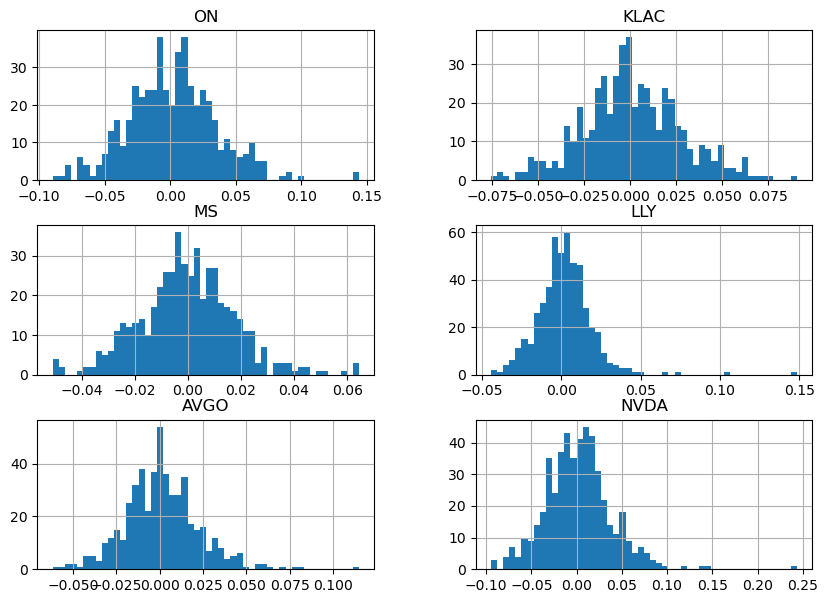

In [31]:
# Biểu đồ hist
return_matrix.hist(bins=50, figsize=(10, 7))

In [32]:
# Ma trận tương quan
correlation_matrix = return_matrix.corr()
print(correlation_matrix)

            ON      KLAC        MS       LLY      AVGO      NVDA
ON    1.000000  0.794689  0.525582  0.127660  0.711442  0.723853
KLAC  0.794689  1.000000  0.532382  0.202262  0.744320  0.761293
MS    0.525582  0.532382  1.000000  0.160017  0.502492  0.516520
LLY   0.127660  0.202262  0.160017  1.000000  0.208452  0.169106
AVGO  0.711442  0.744320  0.502492  0.208452  1.000000  0.711798
NVDA  0.723853  0.761293  0.516520  0.169106  0.711798  1.000000


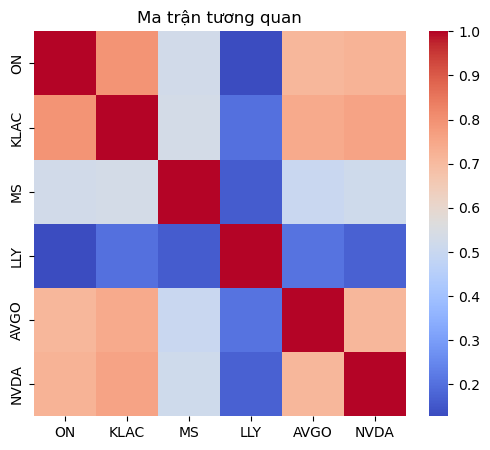

In [33]:
# Trực quan hóa
plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f')
plt.title('Ma trận tương quan')
plt.show()

### Phần 3: Tối ưu thử nghiệm ngày liền trước ngày hôm qua & xác định best_TW cho tương lai gần

##### Bước 1: Tạo ma trận tỷ lệ giá theo phiên

In [34]:
ratio_matrix = return_matrix[selected_stocks] + 1
ratio_matrix = np.array(ratio_matrix)
print(ratio_matrix)
print(ratio_matrix.shape)

[[1.         1.         1.         1.         1.         1.        ]
 [0.97940406 0.99356958 0.99899207 0.98666258 1.00692193 1.01217542]
 [1.01543621 1.00303858 0.99697282 1.02339269 1.01051604 1.01811609]
 ...
 [1.00451862 1.00429512 0.98457213 1.00215958 1.00526138 1.02949497]
 [0.96133661 0.98091742 0.97027724 0.97566372 0.97590275 0.97175206]
 [1.00256234 1.0203833  1.01371443 1.01193857 1.01102068 1.01204125]]
(503, 6)


In [35]:
# Thêm cột tiền mặt
cash = np.ones((duration, 1))

ratio_matrix = np.c_[ratio_matrix, cash]
print(ratio_matrix)

[[1.         1.         1.         ... 1.         1.         1.        ]
 [0.97940406 0.99356958 0.99899207 ... 1.00692193 1.01217542 1.        ]
 [1.01543621 1.00303858 0.99697282 ... 1.01051604 1.01811609 1.        ]
 ...
 [1.00451862 1.00429512 0.98457213 ... 1.00526138 1.02949497 1.        ]
 [0.96133661 0.98091742 0.97027724 ... 0.97590275 0.97175206 1.        ]
 [1.00256234 1.0203833  1.01371443 ... 1.01102068 1.01204125 1.        ]]


#### Xét TW = 5

In [36]:
TW = 5

##### Bước 2: Xây dựng ma trận con dựa trên TW

In [37]:
# Không tính ma trận con trước ma trận con gần đây vì tại thời điểm xét chưa có dữ liệu giá của ngày next2
sub_matrices_number = ((duration - 2) - TW + 1) - 1
print(sub_matrices_number)

496


Lưu ý: luôn chạy lệnh khởi tạo "= []" để reset trước khi tiến hành lệnh "append" để tránh thừa dữ liệu

In [38]:
# Tạo danh sách chứa các ma trận con
sub_matrices = []

for i in range(sub_matrices_number + 1):
    # Loại bỏ ma trận trước ma trận con gần đây vì không có dữ liệu của ngày next2
    if i == sub_matrices_number - 1:
        continue
    sub_matrix = ratio_matrix[i : i + TW]
    sub_matrices.append(sub_matrix)

print(len(sub_matrices))

496


In [39]:
# Tạo danh sách chứa mảng giá của ngày liền sau ngày kế tiếp của TW
train_next2_days = []

for i in range(sub_matrices_number - 1):
    train_next2_day = ratio_matrix[i + TW + 1]
    train_next2_days.append(train_next2_day)

print(len(train_next2_days))

495


##### Bước 3: Biến đổi các ma trận con thành dạng vector

In [40]:
# Tạo danh sách chứa các vector
train_vectors = []

# Biến đổi các ma trận con thành dạng vector
for sub_matrix in sub_matrices:
    vector = sub_matrix.flatten()
    train_vectors.append(vector)

print(len(train_vectors))

496


In [41]:
# Vector gần đây
recent_vector = train_vectors[-1]
print(recent_vector)
print(recent_vector.shape)

[0.95437225 0.97753572 0.98964229 0.99587179 0.97877416 0.99263413
 1.         1.021076   1.00089854 0.9936717  0.99954546 1.00075962
 1.01329008 1.         1.02172732 1.02812191 1.00661361 0.99034124
 1.01859674 1.01462283 1.         0.98830403 1.00124431 0.99367314
 0.98655523 0.99829329 1.00951513 1.         1.00451862 1.00429512
 0.98457213 1.00215958 1.00526138 1.02949497 1.        ]
(35,)


##### Bước 4: Phân cụm các vector

In [42]:
# Số cụm tối đa
max_K = int(np.sqrt(sub_matrices_number))

# Số lần chạy lại thuật toán KMeans
q_number = 10

# Chỉ số silhouete cao nhất
silhouette_max = 0

# Số cụm tối ưu
optimal_K = 0

for K in range(2, max_K + 1):
    kmeans = KMeans(n_clusters=K)
    silhouette_index = 0
    for q in range (q_number):
        kmeans.fit(train_vectors)
        silhouette_q = silhouette_score(train_vectors, kmeans.labels_)
        silhouette_index = silhouette_index + silhouette_q
    silhouette_index = silhouette_index / q_number
    if silhouette_index > silhouette_max:
        silhouette_max = silhouette_index
        optimal_K = K

print("Với TW = {} thì số cụm tối ưu là K = {}, đạt được chỉ số silhouette = {}".format(TW, optimal_K, silhouette_max))


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are

Với TW = 5 thì số cụm tối ưu là K = 5, đạt được chỉ số silhouette = 0.09785916171359822


##### Bước 5: Xác định mẫu tương đồng

In [43]:
# Chọn số cụm là số cụm tối ưu ở bước trước
kmeans = KMeans(n_clusters=optimal_K)

# Tăng số lần lặp lên 30 để tăng độ chính xác
z_number = 30

# Tạo danh sách chứa số lần vector huấn luyện cùng cụm với vector gần đây
same_cluster_count = [0] * (sub_matrices_number - 1)

for z in range(z_number):
    kmeans.fit(train_vectors)
    labels = kmeans.labels_
    for i in range(sub_matrices_number - 1):
        if labels[i] == labels[-1]:
            same_cluster_count[i] = same_cluster_count[i] + 1

print(same_cluster_count)
print(len(same_cluster_count))

c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are

[30, 0, 0, 0, 0, 30, 0, 0, 6, 0, 29, 0, 0, 1, 0, 11, 0, 23, 0, 0, 29, 0, 0, 0, 0, 29, 1, 0, 6, 0, 28, 0, 0, 0, 1, 0, 30, 0, 0, 30, 0, 0, 30, 0, 0, 30, 0, 0, 30, 0, 0, 0, 30, 0, 0, 30, 0, 0, 0, 0, 29, 0, 0, 30, 0, 0, 25, 0, 0, 23, 0, 0, 1, 0, 19, 0, 30, 0, 0, 30, 0, 0, 0, 0, 8, 0, 6, 0, 0, 0, 30, 0, 0, 0, 1, 0, 29, 0, 0, 0, 30, 0, 0, 0, 0, 30, 0, 0, 0, 0, 25, 0, 0, 0, 0, 0, 30, 0, 0, 28, 0, 0, 0, 30, 0, 0, 30, 1, 0, 0, 30, 0, 0, 21, 0, 0, 0, 30, 0, 0, 30, 0, 3, 0, 0, 0, 0, 0, 30, 0, 0, 30, 0, 0, 0, 0, 20, 1, 0, 0, 20, 0, 0, 0, 30, 0, 0, 16, 0, 0, 0, 0, 0, 30, 0, 0, 30, 0, 0, 30, 0, 0, 0, 1, 0, 0, 0, 29, 0, 0, 0, 0, 0, 1, 0, 23, 0, 0, 0, 0, 0, 30, 0, 0, 0, 0, 30, 0, 0, 0, 0, 30, 0, 1, 0, 0, 0, 30, 0, 0, 1, 0, 30, 0, 0, 27, 17, 0, 1, 0, 0, 30, 0, 0, 0, 23, 0, 0, 30, 0, 0, 0, 0, 0, 0, 30, 0, 0, 0, 30, 0, 0, 0, 0, 0, 0, 30, 0, 8, 8, 0, 0, 30, 0, 0, 0, 0, 30, 0, 0, 0, 0, 30, 0, 0, 0, 29, 0, 0, 0, 0, 0, 1, 0, 29, 0, 0, 0, 0, 30, 0, 0, 0, 0, 0, 30, 0, 0, 9, 0, 0, 30, 0, 0, 30, 0, 0, 0, 0, 30, 

In [44]:
# Tạo danh sách chứa chỉ số của các vector tương đồng với vector gần đây
similar_vectors_indices = []

for i in range(sub_matrices_number - 1):
    if same_cluster_count[i] >= z_number * 0.8:
        similar_vectors_indices.append(i)

print(similar_vectors_indices)
print(len(similar_vectors_indices))

[0, 5, 10, 20, 25, 30, 36, 39, 42, 45, 48, 52, 55, 60, 63, 66, 76, 79, 90, 96, 100, 105, 110, 116, 119, 123, 126, 130, 137, 140, 148, 151, 164, 173, 176, 179, 187, 201, 206, 211, 217, 222, 225, 231, 238, 245, 249, 256, 262, 267, 272, 276, 284, 289, 295, 301, 304, 309, 324, 327, 331, 335, 340, 346, 352, 355, 359, 366, 370, 377, 380, 383, 392, 396, 399, 410, 414, 426, 431, 434, 442, 450, 453, 459, 464, 469, 475, 482, 492, 493]
90


##### Bước 6: Dự đoán tỷ lệ giá của ngày hôm sau

In [45]:
# Tạo danh sách chứa độ tương tự cosin của các vector huấn luyện với vector gần đây
cos_similarities = []

for vector_index in similar_vectors_indices:
    cos = (train_vectors[vector_index] @ recent_vector) / (np.linalg.norm(train_vectors[vector_index]) * np.linalg.norm(recent_vector))
    cos_similarities.append(cos)

print(cos_similarities)
print(len(cos_similarities))

[0.9998448557677039, 0.9999380924040846, 0.999864558375387, 0.9996365942746933, 0.9998166682951736, 0.9995632949043473, 0.9996561240475915, 0.9997531039875275, 0.999610421102191, 0.9996654967295052, 0.9994310579322556, 0.9997553147485174, 0.9998367589061116, 0.9997093868403969, 0.9996214811101257, 0.9998035665468488, 0.9995689309044968, 0.9997931149168752, 0.9994536942194177, 0.9997080126428183, 0.9996444599227365, 0.9996737345260042, 0.9998118177857572, 0.9996708478003883, 0.9998122460515898, 0.9996127963358762, 0.9996547907457489, 0.9998044851384761, 0.999715239537315, 0.9995280597038718, 0.9994368987726856, 0.999633689800742, 0.9997134449127938, 0.9997193781158066, 0.999782030533555, 0.9996471843025515, 0.9996841847867303, 0.9997515548740065, 0.9999011215512424, 0.9995262076974758, 0.9996163678378299, 0.99947162691341, 0.9996513036650468, 0.9999236501997306, 0.999907951950492, 0.9997427998882533, 0.9998288612119036, 0.9996891069724709, 0.9998639762175108, 0.9996510162209822, 0.99983

Do chênh lệch giữa các độ tương tự cosin quá nhỏ nên dùng hàm mũ để gia tăng tỷ lệ cách biệt

In [46]:
similarities = np.array(cos_similarities)**64
print(similarities)

[0.99011914 0.99604563 0.99136862 0.97700629 0.98833427 0.9724319
 0.97822865 0.98432092 0.97537047 0.97881581 0.96423267 0.98446024
 0.98960611 0.98157    0.97606139 0.98750573 0.97278288 0.98684527
 0.96563137 0.98148365 0.97749841 0.97933217 0.98802745 0.9791512
 0.98805454 0.97551881 0.97814515 0.9875638  0.98193785 0.97024049
 0.96459339 0.97682462 0.98182504 0.98219804 0.98614531 0.97766892
 0.97998759 0.98422331 0.99369145 0.97012544 0.9757419  0.96674085
 0.9779268  0.99512535 0.99412597 0.98367185 0.98910595 0.98029646
 0.99133167 0.9779088  0.98979115 0.94523519 0.98809674 0.98745335
 0.99232721 0.98588016 0.98473628 0.98834014 0.98818849 0.98185485
 0.98279951 0.99141375 0.98558271 0.98090654 0.98814766 0.98680181
 0.98765222 0.98372399 0.99457433 0.99123017 0.9904796  0.98613454
 0.97297526 0.98487764 0.99064143 0.93226781 0.98287506 0.99130159
 0.99154131 0.98911051 0.98937359 0.98812737 0.99237154 0.96389289
 0.98345102 0.99049665 0.99141909 0.98474413 0.98813818 0.993549

In [47]:
# Tính tổng các độ tương tự
sum_similarities = np.sum(similarities)
print(sum_similarities)

88.43945481345108


In [48]:
# Tạo vector trọng số của mỗi vector
w = np.array(similarities) / sum_similarities
w = w.reshape(-1, 1)
print(w.shape)

(90, 1)


In [49]:
# Tạo ma trận tỷ lệ giá từ các vector tương đồng với vector gần đây
C = []

for vector_index in similar_vectors_indices:
    C.append(train_next2_days[vector_index])

C = np.array(C)
print(C.shape)

(90, 7)


In [50]:
# Tỷ lệ giá dự đoán
predict = w.T @ C
print(predict)

[[1.00008171 0.99847802 0.99828452 1.00118225 0.99849321 0.99706017
  1.        ]]


##### Bước 7: Tối ưu danh mục đầu tư

In [51]:
temp_opt_portfolio = np.full(predict.shape[1] - 1, None)

for i in range(predict.shape[1] - 1):
    if predict[0, i] > 0:
        temp_opt_portfolio[i] = predict[0, i] - 1

# Nếu tất cả cổ phiếu dự đoán âm thì full cash
if np.all(temp_opt_portfolio < 0):
    opt_portfolio = np.zeros(predict.shape[1])
    opt_portfolio[-1] = 1

# Nếu tất cả bằng 0 thì không thay đổi danh mục hôm liền trước
elif np.all(temp_opt_portfolio == 0):
    pass

# Nếu 1 trong các phần tử lớn hơn 0:
else:
    for i in range(predict.shape[1] - 1):
        if temp_opt_portfolio[i] < 0:
            temp_opt_portfolio[i] = 0
    opt_portfolio = np.append(temp_opt_portfolio, 0)
    opt_portfolio = opt_portfolio / np.sum(opt_portfolio)

print(opt_portfolio)

[0.06464332226043938 0.0 0.0 0.9353566777395607 0.0 0.0 0.0]


In [52]:
# Tạo ma trận lưu các mảng opt_portfolio theo TW
opt_TW_matrix = np.array([opt_portfolio])
print(opt_TW_matrix)

[[0.06464332226043938 0.0 0.0 0.9353566777395607 0.0 0.0 0.0]]


#### Xét TW từ 6 đến 10

In [53]:
for TW in range(6, 11):
    # BƯỚC 2: Xây dựng ma trận con dựa trên TW
    # Không tính ma trận con trước ma trận con gần đây vì tại thời điểm xét chưa có dữ liệu giá của ngày next2
    sub_matrices_number = ((duration - 2) - TW + 1) - 1

    # Tạo danh sách chứa các ma trận con
    sub_matrices = []
    for i in range(sub_matrices_number + 1):
        # Loại bỏ ma trận trước ma trận con gần đây vì không có dữ liệu của ngày next2
        if i == sub_matrices_number - 1:
            continue
        sub_matrix = ratio_matrix[i : i + TW]
        sub_matrices.append(sub_matrix)

    # Tạo danh sách chứa mảng giá của ngày liền sau ngày kế tiếp của TW
    train_next2_days = []
    for i in range(sub_matrices_number - 1):
        train_next2_day = ratio_matrix[i + TW + 1]
        train_next2_days.append(train_next2_day)

    # BƯỚC 3: Biến đổi các ma trận con thành dạng vector
    # Tạo danh sách chứa các vector
    train_vectors = []

    # Biến đổi các ma trận con thành dạng vector
    for sub_matrix in sub_matrices:
        vector = sub_matrix.flatten()
        train_vectors.append(vector)

    # Vector gần đây
    recent_vector = train_vectors[-1]

    # BƯỚC 4: Phân cụm các vector
    # Số cụm tối đa
    max_K = int(np.sqrt(sub_matrices_number))
    # Số lần chạy lại thuật toán KMeans
    q_number = 10
    # Chỉ số silhouete cao nhất
    silhouette_max = 0
    # Số cụm tối ưu
    optimal_K = 0

    for K in range(2, max_K + 1):
        kmeans = KMeans(n_clusters=K)
        silhouette_index = 0
        for q in range (q_number):
            kmeans.fit(train_vectors)
            silhouette_q = silhouette_score(train_vectors, kmeans.labels_)
            silhouette_index = silhouette_index + silhouette_q
        silhouette_index = silhouette_index / q_number
        if silhouette_index > silhouette_max:
            silhouette_max = silhouette_index
            optimal_K = K

    # BƯỚC 5: Xác định mẫu tương đồng
    # Chọn số cụm là số cụm tối ưu ở bước trước
    kmeans = KMeans(n_clusters=optimal_K)
    # Tăng số lần lặp lên 30 để tăng độ chính xác
    z_number = 30

    # Tạo danh sách chứa số lần vector huấn luyện cùng cụm với vector gần đây
    same_cluster_count = [0] * (sub_matrices_number - 1)
    for z in range(z_number):
        kmeans.fit(train_vectors)
        labels = kmeans.labels_
        for i in range(sub_matrices_number - 1):
            if labels[i] == labels[-1]:
                same_cluster_count[i] = same_cluster_count[i] + 1

    # Tạo danh sách chứa chỉ số của các vector tương đồng với vector gần đây
    similar_vectors_indices = []
    for i in range(sub_matrices_number - 1):
        if same_cluster_count[i] >= z_number * 0.8:
            similar_vectors_indices.append(i)

    # BƯỚC 6: Dự đoán tỷ lệ giá của ngày hôm sau
    # Tạo danh sách chứa độ tương tự cosin của các vector huấn luyện với vector gần đây
    cos_similarities = []
    for vector_index in similar_vectors_indices:
        cos = (train_vectors[vector_index] @ recent_vector) / (np.linalg.norm(train_vectors[vector_index]) * np.linalg.norm(recent_vector))
        cos_similarities.append(cos)
    
    # Do chênh lệch giữa các độ tương tự cosin quá nhỏ nên dùng hàm mũ để gia tăng tỷ lệ cách biệt
    similarities = np.array(cos_similarities)**64
    # Tính tổng các độ tương tự
    sum_similarities = np.sum(similarities)
    # Tạo vector trọng số của mỗi vector
    w = np.array(similarities) / sum_similarities
    w = w.reshape(-1, 1)
    
    # Tạo ma trận tỷ lệ giá từ các vector tương đồng với vector gần đây
    C = []
    for vector_index in similar_vectors_indices:
        C.append(train_next2_days[vector_index])
    C = np.array(C)

    # Tỷ lệ giá dự đoán
    predict = w.T @ C

    # BƯỚC 7: Tối ưu danh mục đầu tư
    temp_opt_portfolio = np.full(predict.shape[1] - 1, None)
    for i in range(predict.shape[1] - 1):
        if predict[0, i] > 0:
            temp_opt_portfolio[i] = predict[0, i] - 1

    # Nếu tất cả cổ phiếu dự đoán âm thì full cash
    if np.all(temp_opt_portfolio < 0):
        opt_portfolio = np.zeros(predict.shape[1])
        opt_portfolio[-1] = 1
    # Nếu tất cả bằng 0 thì không thay đổi danh mục hôm liền trước
    elif np.all(temp_opt_portfolio == 0):
        pass
    # Nếu 1 trong các phần tử lớn hơn 0:
    else:
        for i in range(predict.shape[1] - 1):
            if temp_opt_portfolio[i] < 0:
                temp_opt_portfolio[i] = 0
        opt_portfolio = np.append(temp_opt_portfolio, 0)
        opt_portfolio = opt_portfolio / np.sum(opt_portfolio)

    # Lưu opt_portfolio vào ma trận
    opt_TW_matrix = np.vstack((opt_TW_matrix, opt_portfolio))

print(opt_TW_matrix)
print(opt_TW_matrix.shape)


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are

[[0.06464332226043938 0.0 0.0 0.9353566777395607 0.0 0.0 0.0]
 [0.0 0.0 0.0 1.0 0.0 0.0 0.0]
 [0.0392771601579995 0.4350266948174431 0.0 0.21496890920437214
  0.054847861062763126 0.2558793747574222 0.0]
 [0.29250148869902215 0.2527307361760176 0.0 0.11547384838303044
  0.07107886514318645 0.26821506159874337 0.0]
 [0.41569638389462477 0.29720138898860066 0.022347623892468232 0.0
  0.11774856282178556 0.14700604040252077 0.0]
 [0.33394669713986125 0.171426331186396 0.13561395244278385
  0.21835329001898418 0.14065972921197475 0.0 0.0]]
(6, 7)


#### Xác định best_TW cho tương lai gần vào ngày tiếp theo

In [54]:
# Tỷ lệ giá ở ngày tiếp theo
print(ratio_matrix[duration - 1])

[1.00256234 1.0203833  1.01371443 1.01193857 1.01102068 1.01204125
 1.        ]


In [55]:
# Lợi nhuận ở ngày tiếp theo theo từng TW
TW_return = opt_TW_matrix @ ratio_matrix[duration - 1]
print(TW_return)

[1.0113324628290448 1.011938573663061 1.0152199122863226
 1.0112925502780385 1.010497392081546 1.0103667806424201]


In [56]:
# Xác định best_TW cho tương lai gần
TW_arr = np.arange(5, 11)
best_TW_index = np.argmax(TW_return)
best_TW = TW_arr[best_TW_index]
print(best_TW)

7


### Phần 4: Thực hiện tối ưu danh mục đầu tư vào ngày hôm nay

#### 4.1 Tối ưu danh mục

Dùng danh sách cổ phiếu lọc ở phần 2 và best_TW ở phần 3

##### Bước 1: Tạo ma trận tỷ lệ giá theo phiên

Đã có sẵn từ phần 3

##### Bước 2: Xây dựng ma trận con dựa trên TW

In [57]:
# Không tính ma trận con trước ma trận con gần đây vì tại thời điểm xét chưa có dữ liệu giá của ngày next2
sub_matrices_number = ((duration - 2) - best_TW + 1) - 1
print(sub_matrices_number)

494


In [58]:
# Tạo danh sách chứa các ma trận con
sub_matrices = []

for i in range(sub_matrices_number + 1):
    # Loại bỏ ma trận trước ma trận con gần đây vì không có dữ liệu của ngày next2
    if i == sub_matrices_number - 1:
        continue
    sub_matrix = ratio_matrix[i+2 : i+best_TW+2]
    sub_matrices.append(sub_matrix)

print(len(sub_matrices))

494


In [59]:
# Tạo danh sách chứa mảng giá của ngày liền sau ngày kế tiếp của TW
train_next2_days = []

for i in range(sub_matrices_number - 1):
    train_next2_day = ratio_matrix[i + best_TW + 1 + 2]
    train_next2_days.append(train_next2_day)

print(len(train_next2_days))

493


##### Bước 3: Biến đổi các ma trận con thành dạng vector

In [60]:
# Tạo danh sách chứa các vector
train_vectors = []

# Biến đổi các ma trận con thành dạng vector
for sub_matrix in sub_matrices:
    vector = sub_matrix.flatten()
    train_vectors.append(vector)

print(len(train_vectors))

494


In [61]:
# Vector gần đây
recent_vector = train_vectors[-1]
print(recent_vector)
print(recent_vector.shape)

[0.95437225 0.97753572 0.98964229 0.99587179 0.97877416 0.99263413
 1.         1.021076   1.00089854 0.9936717  0.99954546 1.00075962
 1.01329008 1.         1.02172732 1.02812191 1.00661361 0.99034124
 1.01859674 1.01462283 1.         0.98830403 1.00124431 0.99367314
 0.98655523 0.99829329 1.00951513 1.         1.00451862 1.00429512
 0.98457213 1.00215958 1.00526138 1.02949497 1.         0.96133661
 0.98091742 0.97027724 0.97566372 0.97590275 0.97175206 1.
 1.00256234 1.0203833  1.01371443 1.01193857 1.01102068 1.01204125
 1.        ]
(49,)


##### Bước 4: Phân cụm các vector

In [62]:
# Số cụm tối đa
max_K = int(np.sqrt(sub_matrices_number))

# Số lần chạy lại thuật toán KMeans
q_number = 10

# Chỉ số silhouete cao nhất
silhouette_max = 0

# Số cụm tối ưu
optimal_K = 0

for K in range(2, max_K + 1):
    kmeans = KMeans(n_clusters=K)
    silhouette_index = 0
    for q in range (q_number):
        kmeans.fit(train_vectors)
        silhouette_q = silhouette_score(train_vectors, kmeans.labels_)
        silhouette_index = silhouette_index + silhouette_q
    silhouette_index = silhouette_index / q_number
    if silhouette_index > silhouette_max:
        silhouette_max = silhouette_index
        optimal_K = K

print("Với TW = {} thì số cụm tối ưu là K = {}, đạt được chỉ số silhouette = {}".format(best_TW, optimal_K, silhouette_max))

c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are

Với TW = 7 thì số cụm tối ưu là K = 2, đạt được chỉ số silhouette = 0.06975808424061884


##### Bước 5: Xác định mẫu tương đồng

In [63]:
# Chọn số cụm là số cụm tối ưu ở bước trước
kmeans = KMeans(n_clusters=optimal_K)

# Tăng số lần lặp lên 30 để tăng độ chính xác
z_number = 30

# Tạo danh sách chứa số lần vector huấn luyện cùng cụm với vector gần đây
same_cluster_count = [0] * (sub_matrices_number - 1)

for z in range(z_number):
    kmeans.fit(train_vectors)
    labels = kmeans.labels_
    for i in range(sub_matrices_number - 1):
        if labels[i] == labels[-1]:
            same_cluster_count[i] = same_cluster_count[i] + 1

print(same_cluster_count)
print(len(same_cluster_count))

c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are

[1, 15, 16, 23, 15, 0, 13, 0, 16, 24, 0, 9, 0, 16, 24, 0, 13, 2, 17, 14, 0, 4, 0, 16, 25, 0, 15, 25, 10, 24, 13, 5, 29, 15, 15, 24, 7, 8, 15, 23, 18, 18, 0, 13, 28, 14, 26, 1, 7, 29, 16, 25, 2, 27, 14, 1, 16, 29, 29, 15, 0, 13, 24, 27, 24, 29, 15, 27, 14, 5, 28, 16, 29, 14, 4, 19, 16, 30, 14, 0, 0, 16, 30, 28, 14, 1, 12, 27, 30, 14, 7, 4, 16, 16, 30, 14, 1, 16, 30, 14, 2, 16, 16, 26, 14, 2, 16, 16, 27, 1, 14, 1, 3, 8, 16, 26, 5, 14, 0, 16, 29, 26, 22, 8, 29, 12, 23, 26, 16, 15, 16, 26, 2, 9, 15, 14, 24, 5, 28, 6, 16, 29, 14, 1, 7, 14, 13, 25, 16, 30, 15, 4, 13, 6, 18, 1, 14, 16, 27, 2, 8, 2, 18, 25, 15, 30, 14, 14, 8, 24, 29, 28, 1, 5, 29, 13, 16, 30, 14, 12, 7, 15, 1, 16, 30, 30, 14, 0, 10, 24, 2, 12, 15, 17, 21, 14, 0, 9, 16, 18, 19, 0, 2, 16, 30, 14, 0, 10, 4, 16, 30, 15, 6, 9, 23, 21, 14, 5, 28, 29, 17, 13, 7, 30, 25, 13, 10, 16, 16, 30, 15, 14, 0, 16, 30, 16, 30, 15, 14, 13, 14, 28, 29, 14, 0, 16, 16, 30, 15, 14, 13, 11, 30, 25, 28, 8, 9, 25, 0, 15, 18, 15, 2, 25, 5, 29, 14, 1, 13

In [64]:
# Tạo danh sách chứa chỉ số của các vector tương đồng với vector gần đây
similar_vectors_indices = []

for i in range(sub_matrices_number - 1):
    if same_cluster_count[i] >= z_number * 0.8:
        similar_vectors_indices.append(i)

print(similar_vectors_indices)
print(len(similar_vectors_indices))

[9, 14, 24, 27, 29, 32, 35, 44, 46, 49, 51, 53, 57, 58, 62, 63, 64, 65, 67, 70, 72, 77, 82, 83, 87, 88, 94, 98, 103, 108, 115, 120, 121, 124, 127, 131, 136, 138, 141, 147, 149, 158, 163, 165, 169, 170, 171, 174, 177, 184, 185, 189, 204, 210, 218, 219, 223, 224, 229, 234, 236, 241, 242, 247, 252, 253, 254, 257, 263, 265, 270, 275, 282, 287, 295, 300, 302, 305, 313, 322, 329, 333, 338, 344, 349, 357, 360, 362, 369, 374, 375, 379, 380, 383, 388, 393, 394, 398, 403, 408, 413, 420, 424, 429, 432, 442, 446, 447, 451, 456, 457, 461, 462, 467, 473, 478, 482, 484, 486, 489, 490, 491]
122


##### Bước 6: Dự đoán tỷ lệ giá của ngày hôm sau

In [65]:
# Tạo danh sách chứa độ tương tự cosin của các vector huấn luyện với vector gần đây
cos_similarities = []

for vector_index in similar_vectors_indices:
    cos = (train_vectors[vector_index] @ recent_vector) / (np.linalg.norm(train_vectors[vector_index]) * np.linalg.norm(recent_vector))
    cos_similarities.append(cos)

print(cos_similarities)
print(len(cos_similarities))

[0.9998604926088461, 0.9995578282851929, 0.9998245464518586, 0.9997672458144272, 0.9995972297718734, 0.9998078988143707, 0.9996810891177574, 0.9994269034320016, 0.9994998758030906, 0.9995990202338135, 0.9998305409609896, 0.9998455628245946, 0.9997790776640245, 0.9996091671323358, 0.9996364746563121, 0.9997336557782398, 0.999543627927924, 0.9996578138591204, 0.9995034672305805, 0.9995555267388163, 0.9997320501172983, 0.9997708273769472, 0.9995425482527088, 0.9996182121740625, 0.9994714732965084, 0.9995417152014252, 0.9997494103027513, 0.999674095765049, 0.9996643845294253, 0.999795872976366, 0.999715073099189, 0.9996316803482358, 0.9995426376838913, 0.9996287697057912, 0.9996083259085694, 0.9997767561842599, 0.9995035082117817, 0.9995516678618281, 0.9992567388255645, 0.999424219101905, 0.9996053412894843, 0.9997043332980838, 0.999634424945592, 0.9996507231167783, 0.999544088468123, 0.9994091580903347, 0.999547237336047, 0.9994729122322176, 0.9996689794719037, 0.9996730511695388, 0.99971

Do chênh lệch giữa các độ tương tự cosin quá nhỏ nên dùng hàm mũ để gia tăng tỷ lệ cách biệt

In [66]:
similarities = np.array(cos_similarities)**64
print(similarities)

[0.99111065 0.97209159 0.98883281 0.98521242 0.97454704 0.98777963
 0.97979339 0.96397618 0.96849113 0.97465877 0.98921231 0.99016395
 0.98595892 0.97529217 0.9769988  0.9830962  0.97120814 0.97833448
 0.96871388 0.97194835 0.98299515 0.98543833 0.971141   0.97585713
 0.96673134 0.9710892  0.9840882  0.97935482 0.97874612 0.98701952
 0.98192738 0.97669896 0.97114656 0.97651697 0.97523964 0.98581241
 0.96871642 0.97170823 0.95352808 0.96381049 0.9750533  0.9812525
 0.9768706  0.97789045 0.97123678 0.96288137 0.97143262 0.96682042
 0.97903408 0.97928933 0.98189436 0.98412881 0.98150524 0.97793595
 0.97733713 0.97079543 0.97718453 0.98389891 0.98993142 0.98504915
 0.98807501 0.9808009  0.98085749 0.97822729 0.97353786 0.96333218
 0.97715576 0.97428235 0.98487546 0.98079256 0.96767693 0.96318807
 0.98947732 0.98581382 0.97774105 0.98916077 0.98512751 0.98215721
 0.98557096 0.97815938 0.98352492 0.99162538 0.98342651 0.98211775
 0.98449521 0.98958932 0.98470186 0.99201243 0.98939295 0.98626

In [67]:
# Tính tổng các độ tương tự
sum_similarities = np.sum(similarities)
print(sum_similarities)

119.58016174234186


In [68]:
# Tạo vector trọng số của mỗi vector
w = np.array(similarities) / sum_similarities
w = w.reshape(-1, 1)
print(w.shape)

(122, 1)


In [69]:
# Tạo ma trận tỷ lệ giá từ các vector tương đồng với vector gần đây
C = []

for vector_index in similar_vectors_indices:
    C.append(train_next2_days[vector_index])

C = np.array(C)
print(C.shape)

(122, 7)


In [70]:
# Tỷ lệ giá dự đoán
predict = w.T @ C
print(predict)

[[1.00477606 1.00184423 1.00055331 1.00262878 1.00330914 1.00340505
  1.        ]]


##### Bước 7: Tối ưu danh mục đầu tư

In [71]:
temp_opt_portfolio = np.full(predict.shape[1] - 1, None)

for i in range(predict.shape[1] - 1):
    if predict[0, i] > 0:
        temp_opt_portfolio[i] = predict[0, i] - 1

# Nếu tất cả cổ phiếu dự đoán âm thì full cash
if np.all(temp_opt_portfolio < 0):
    opt_portfolio = np.zeros(predict.shape[1])
    opt_portfolio[-1] = 1

# Nếu tất cả bằng 0 thì không thay đổi danh mục hôm liền trước
elif np.all(temp_opt_portfolio == 0):
    pass

# Nếu 1 trong các phần tử lớn hơn 0:
else:
    for i in range(predict.shape[1] - 1):
        if temp_opt_portfolio[i] < 0:
            temp_opt_portfolio[i] = 0
    opt_portfolio = np.append(temp_opt_portfolio, 0)
    opt_portfolio = opt_portfolio / np.sum(opt_portfolio)

print(opt_portfolio)

[0.28916802389873514 0.11165936241042224 0.03350023677134872
 0.15916018197652762 0.20035274573104367 0.20615944921192264 0.0]


#### 4.2 Xác định kết quả

In [72]:
print(selected_stocks)

['ON', 'KLAC', 'MS', 'LLY', 'AVGO', 'NVDA']


In [73]:
# Tạo mảng giá ngày hôm qua
yesterday_price = price_matrix[selected_stocks].iloc[-1].to_numpy()
print(yesterday_price)

[ 89.98999786 461.04998779  79.08999634 531.46002197 823.80999756
 440.41000366]


In [ ]:
# Nhập mảng giá cổ phiếu ngày hôm nay (lấy vào lúc 4h sáng ngày hôm sau - tạm thời chưa có dữ liệu nên lấy thủ công)
